In [2]:
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Ruta a la carpeta con archivos CSV en tu Drive
carpeta = '/content/drive/MyDrive/Modelos_actualizados_flujosnorma2'  # Ajusta si es necesario

# Lista para guardar todos los flujos
todos_los_datos = []

for archivo in os.listdir(carpeta):
    if archivo.endswith('.csv'):
        ruta_archivo = os.path.join(carpeta, archivo)
        paciente_id = os.path.splitext(archivo)[0]

        # Leer el archivo CSV con encabezados 'Reaction' y 'Flux'
        df = pd.read_csv(ruta_archivo, sep=",", usecols=['Reaction', 'Flux_Normalized'])

        # Agregar identificador de paciente
        df['paciente'] = paciente_id

        todos_los_datos.append(df)

# Combinar todos los DataFrames
df_completo = pd.concat(todos_los_datos, ignore_index=True)

# Guardar el archivo combinado
df_completo.to_csv('/content/drive/MyDrive/flujos_reacciones_unificados.csv', index=False)

print("✅ Archivo combinado guardado como 'flujos_reacciones_unificados.csv'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Archivo combinado guardado como 'flujos_reacciones_unificados.csv'


🔍 Varianza explicada acumulada (PCA):
[0.04619224 0.07353816]


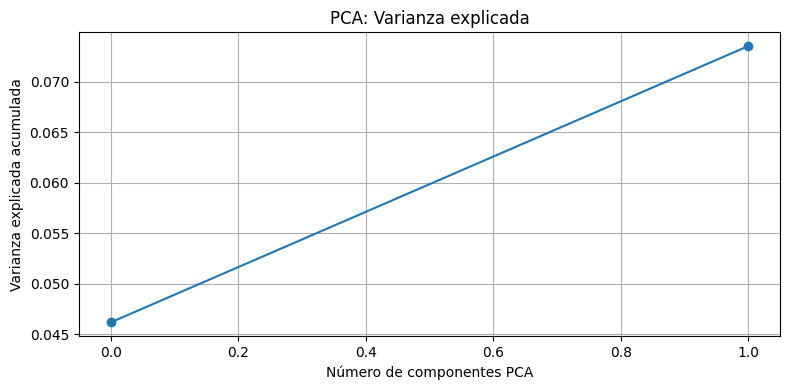

=== DBSCAN sweep eps=0.1 a 20.0 (min_samples=1) usando PCA(2) ===
eps=0.1 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.2 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.3 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.4 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.5 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.6 | clusters= 60 | noise=   0 | silhouette=-1.000
eps=0.7 | clusters= 59 | noise=   0 | silhouette=0.023
eps=0.8 | clusters= 59 | noise=   0 | silhouette=0.023
eps=0.9 | clusters= 59 | noise=   0 | silhouette=0.023
eps=1.0 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.1 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.2 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.3 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.4 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.5 | clusters= 58 | noise=   0 | silhouette=0.045
eps=1.6 | clusters= 57 | noise=   0 | silhouette=0.057
eps=1.7 | clusters= 56 | noise=   0 | silhouette

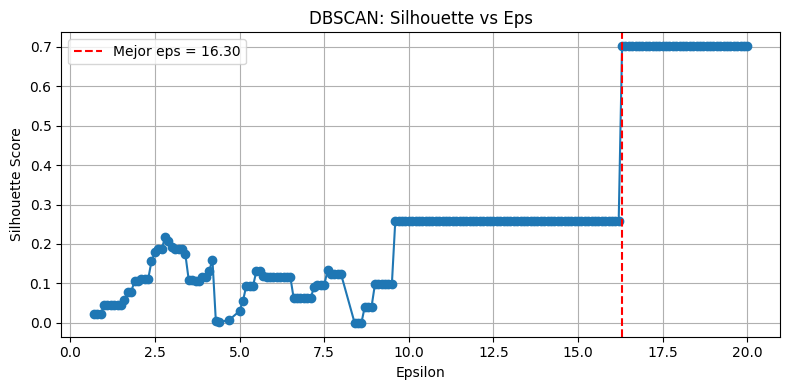


=== KMeans sweep k=2 a 20 usando PCA(2) ===
k= 2 | Silhouette Score=0.446
k= 3 | Silhouette Score=0.340
k= 4 | Silhouette Score=0.393
k= 5 | Silhouette Score=0.385
k= 6 | Silhouette Score=0.338
k= 7 | Silhouette Score=0.390
k= 8 | Silhouette Score=0.379
k= 9 | Silhouette Score=0.420
k=10 | Silhouette Score=0.437
k=11 | Silhouette Score=0.430
k=12 | Silhouette Score=0.417
k=13 | Silhouette Score=0.407
k=14 | Silhouette Score=0.371
k=15 | Silhouette Score=0.371
k=16 | Silhouette Score=0.364
k=17 | Silhouette Score=0.356
k=18 | Silhouette Score=0.354
k=19 | Silhouette Score=0.343
k=20 | Silhouette Score=0.330

🟢 Mejor k = 2 | Silhouette Score = 0.446
✅ Resultado K-Means guardado en 'resultado_kmeans.csv'


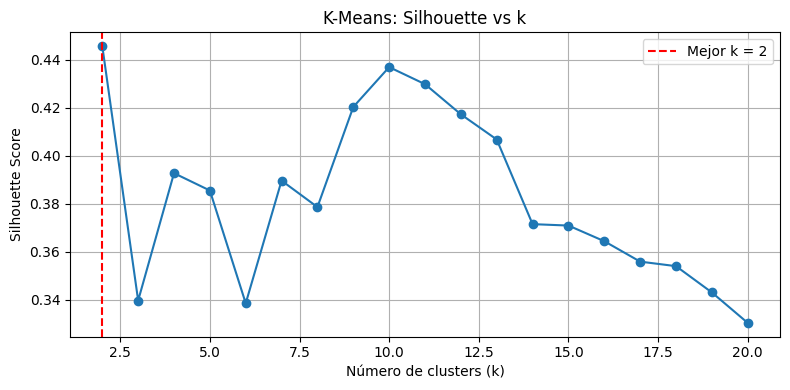

IndexError: index 2 is out of bounds for axis 1 with size 2

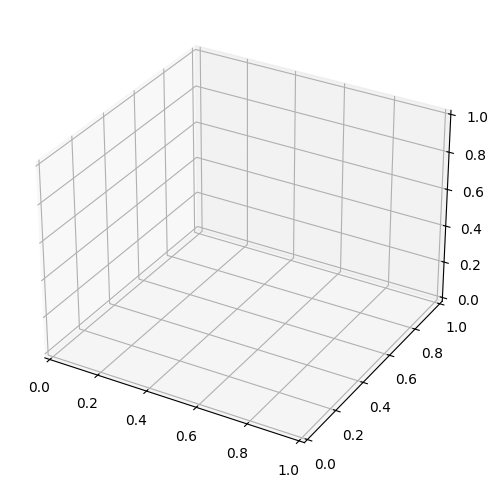

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 1. Cargar los datos ===
df_flujos = pd.read_csv('/content/drive/MyDrive/flujos_reacciones_unificados.csv')
df_flujos['Flux_Normalized'] = pd.to_numeric(df_flujos['Flux_Normalized'], errors='coerce')
df_flujos = df_flujos.dropna(subset=['Flux_Normalized'])

# === 2. Pivotear ===
df_pivot = df_flujos.pivot_table(index='paciente', columns='Reaction', values='Flux_Normalized')

# === 3. Imputar y escalar ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_pivot)

# === 4. PCA con más componentes ===
n_pca_components = 2  # Cambia este valor si quieres más o menos componentes
scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X_imputed)

pca = PCA(n_components=n_pca_components)
X_pca = pca.fit_transform(X_scaled_std)

# === 5. Varianza explicada acumulada ===
print("🔍 Varianza explicada acumulada (PCA):")
print(np.cumsum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes PCA")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA: Varianza explicada")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. DBSCAN sweep ===
results = []
print(f"=== DBSCAN sweep eps=0.1 a 20.0 (min_samples=1) usando PCA({n_pca_components}) ===")
for eps in np.arange(0.1, 20.1, 0.1):
    db = DBSCAN(eps=eps, min_samples=1)
    labels = db.fit_predict(X_pca)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if 1 < n_clusters < len(X_pca):
        score = silhouette_score(X_pca, labels)
    else:
        score = -1

    results.append((eps, n_clusters, n_noise, score))

    if n_clusters > 1:
        print(f"eps={eps:.1f} | clusters={n_clusters:3d} | noise={n_noise:4d} | silhouette={score:.3f}")

# === 7. Mejor resultado DBSCAN ===
valid_results = [r for r in results if r[3] > 0]
if valid_results:
    best = max(valid_results, key=lambda x: x[3])
    print(f"\n🟢 Mejor eps: {best[0]:.2f} | Clusters: {best[1]} | Silhouette: {best[3]:.3f}")

    best_db = DBSCAN(eps=best[0], min_samples=1)
    best_labels = best_db.fit_predict(X_pca)

    df_dbscan = df_pivot.copy()
    df_dbscan['cluster'] = best_labels
    df_dbscan.to_csv('/content/drive/MyDrive/resultado_dbscan_eps20.csv')
    print("✅ Resultado DBSCAN guardado en 'resultado_dbscan_eps20.csv'")

    # Visualización
    plt.figure(figsize=(8, 4))
    eps_vals = [r[0] for r in valid_results]
    scores = [r[3] for r in valid_results]
    plt.plot(eps_vals, scores, marker='o')
    plt.axvline(best[0], color='red', linestyle='--', label=f'Mejor eps = {best[0]:.2f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.title('DBSCAN: Silhouette vs Eps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ DBSCAN aún no detecta múltiples clusters.")

# === 8. KMeans sweep ===
results_kmeans = []
print(f"\n=== KMeans sweep k=2 a 20 usando PCA({n_pca_components}) ===")
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    results_kmeans.append((k, score))
    print(f"k={k:2d} | Silhouette Score={score:.3f}")

# === 9. Mejor resultado KMeans ===
best_k = max(results_kmeans, key=lambda x: x[1])
print(f"\n🟢 Mejor k = {best_k[0]} | Silhouette Score = {best_k[1]:.3f}")

# Guardar resultados
kmeans = KMeans(n_clusters=best_k[0], random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

df_kmeans = df_pivot.copy()
df_kmeans['cluster'] = labels
df_kmeans.to_csv('/content/drive/MyDrive/resultado_kmeans.csv')
print("✅ Resultado K-Means guardado en 'resultado_kmeans.csv'")

# Visualización Silhouette KMeans
k_vals = [r[0] for r in results_kmeans]
scores = [r[1] for r in results_kmeans]

plt.figure(figsize=(8, 4))
plt.plot(k_vals, scores, marker='o')
plt.axvline(best_k[0], color='red', linestyle='--', label=f'Mejor k = {best_k[0]}')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette vs k')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Visualización 3D (solo primeras 3 componentes)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab10', s=50)
ax.set_title(f"K-Means clustering (k={best_k[0]}) sobre PCA({n_pca_components})")
plt.show()
